In [32]:
import nibabel as nib
import pandas as pd
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization, Dense, Dropout, Flatten
from keras.metrics import Accuracy, BinaryAccuracy
from keras.models import load_model


def load(file_path):
    # Read file
    img = nib.load(file_path)
    # Get raw data
    img = img.get_fdata()
    return img

def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return ((img - mean) / std).astype("float32")

def resize(img):
    width_factor = 1 / (img.shape[0] / 128)
    height_factor = 1 / (img.shape[1] / 128)
    depth_factor = 1 / (img.shape[-1] / 64)
    # img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_image(path):
    img = load(path)
    img = normalize(img)
    img = resize(img)
    return img

In [2]:
labels_df = pd.read_csv(os.path.join("/scratch/kpairoj", "BSE_BET_DATA", "labels.csv"))
labels_df.head()

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,Yes,No
1,IXI448-HH-2393-T1_bet_07.nii,Yes,No
2,IXI252-HH-1693-T1_bet_08.nii,Yes,No
3,IXI188-Guys-0798-T1_bet_17.nii,Yes,No
4,IXI182-Guys-0792-T1_bet_17.nii,Yes,No


In [3]:
file_names = os.listdir(os.path.join("/scratch/kpairoj", "BSE_BET_DATA", "files"))
file_names[:2]

['IXI002-Guys-0828-T1_bet_09.nii.gz', 'IXI002-Guys-0828-T1_bet_5.nii.gz']

In [4]:
file_paths = [os.path.join("/scratch/kpairoj", "BSE_BET_DATA", "files", f) for f in file_names]
file_paths[:2]

['/scratch/kpairoj/BSE_BET_DATA/files/IXI002-Guys-0828-T1_bet_09.nii.gz',
 '/scratch/kpairoj/BSE_BET_DATA/files/IXI002-Guys-0828-T1_bet_5.nii.gz']

In [5]:
norm_images = np.array([])

if os.path.exists("norm_images.npy"):
    norm_images = np.load("norm_images.npy")
else:
    norm_images = np.array([process_image(p) for p in file_paths])
    np.save("norm_images", norm_images)

In [6]:
norm_images.shape

(2060, 128, 128, 64)

In [7]:
labels_facial = np.array([])
labels_brain = np.array([])
for n in file_names:
    labels_facial = np.append(labels_facial, labels_df[labels_df["Filename"] == n.strip(".gz")]["Recognizable-Facial-Feature"])
    labels_brain = np.append(labels_brain, labels_df[labels_df["Filename"] == n.strip(".gz")]["Brain-Feature-Loss"])
print(labels_facial[:2], labels_brain[:2])

['Yes' 'No'] ['No' 'Yes']


In [8]:
labels_facial = np.array([1 if label == 'Yes' else 0 for label in labels_facial])
labels_brain = np.array([1 if label == 'Yes' else 0 for label in labels_brain])
print(labels_facial[:2], labels_brain[:2])

[1 0] [0 1]


In [9]:
X_train, X_test, Y_f_train, Y_f_test, Y_b_train, Y_b_test = train_test_split(norm_images, labels_facial, labels_brain, test_size=0.4, random_state=42)

In [10]:
x_train, x_val, y_f_train, y_f_val, y_b_train, y_b_val = train_test_split(X_train, Y_f_train, Y_b_train, test_size=0.4, random_state=42)

In [11]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        angles = [-30, -15, -5, 5, 15, 30]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    aug_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return aug_volume


def train_preprocessing(volume, label):
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [12]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, {"facial": y_f_train, "brain": y_b_train}))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, {"facial": y_f_val, "brain": y_b_val}))

batch_size = 8
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

2023-04-18 22:55:41.939351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 22:55:42.467127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38176 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
def define_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))

    x = Conv3D(filters=32, kernel_size=(3,3,3), activation="relu")(inputs)
    x = MaxPooling3D(pool_size=(2,2,2))(x)

    x = Conv3D(filters=64, kernel_size=(3,3,3), activation="relu")(x)
    x = MaxPooling3D(pool_size=(2,2,2))(x)

    x = Conv3D(filters=128, kernel_size=(3,3,3), activation="relu")(x)
    x = MaxPooling3D(pool_size=(2,2,2))(x)
    
    # Normalize and flatten before feeding to MLP architecture
    x = BatchNormalization()(x)
    flatten = Flatten()(x)
                     
    # Avoid overfitting and perform regularization
    f = Dense(units=256, activation="relu")(flatten)
    f = Dropout(0.2)(f)
    f = Dense(units=16, activation="relu")(f)
    f = Dropout(0.2)(f)
    out_f = Dense(units=1, activation='sigmoid', name='facial')(f)
    
    b = Dense(units=256, activation="relu")(flatten)
    b = Dropout(0.2)(b)
    b = Dense(units=16, activation="relu")(b)
    b = Dropout(0.2)(b)
    out_b = Dense(units=1, activation='sigmoid', name='brain')(b)

    # Define the model.
    model = keras.Model(inputs, [out_f, out_b], name="3dcnn")
    return model


# Build model.
model = define_model()
model.summary()

Model: "3dcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_12 (Conv3D)             (None, 126, 126, 62  896         ['input_4[0][0]']                
                                , 32)                                                             
                                                                                                  
 max_pooling3d_12 (MaxPooling3D  (None, 63, 63, 31,   0          ['conv3d_12[0][0]']              
 )                              32)                                                           

In [21]:
if os.path.exists("project.h5"):
    model = load_model("project.h5")
    
model.compile(
    optimizer=Adam(0.001),
    loss="binary_crossentropy",
    metrics=[Accuracy()],
)

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("project.h5", save_best_only=True)
early_stopping_f_acc_cb = tf.keras.callbacks.EarlyStopping(monitor="val_facial_accuracy", mode="max", patience=15)
early_stopping_b_acc_cb = tf.keras.callbacks.EarlyStopping(monitor="val_brain_accuracy", mode="max", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    batch_size=batch_size,
    callbacks=[checkpoint_cb, early_stopping_f_acc_cb, early_stopping_b_acc_cb],
)

model.save("project.h5", save_format="h5")

Epoch 1/50
93/93 - 84s - loss: 1.6075 - facial_loss: 0.7059 - brain_loss: 0.9015 - facial_accuracy: 0.1484 - brain_accuracy: 0.1350 - val_loss: 6.5059 - val_facial_loss: 2.0199 - val_brain_loss: 4.4859 - val_facial_accuracy: 0.2162 - val_brain_accuracy: 0.0000e+00 - 84s/epoch - 903ms/step
Epoch 2/50
93/93 - 83s - loss: 0.4003 - facial_loss: 0.1398 - brain_loss: 0.2605 - facial_accuracy: 0.0445 - brain_accuracy: 0.0499 - val_loss: 0.6935 - val_facial_loss: 0.1415 - val_brain_loss: 0.5520 - val_facial_accuracy: 0.0202 - val_brain_accuracy: 0.0000e+00 - 83s/epoch - 892ms/step
Epoch 3/50
93/93 - 84s - loss: 0.2534 - facial_loss: 0.0995 - brain_loss: 0.1540 - facial_accuracy: 0.0189 - brain_accuracy: 0.0310 - val_loss: 0.2073 - val_facial_loss: 0.0640 - val_brain_loss: 0.1433 - val_facial_accuracy: 0.1071 - val_brain_accuracy: 0.0000e+00 - 84s/epoch - 903ms/step
Epoch 4/50
93/93 - 85s - loss: 0.1929 - facial_loss: 0.0860 - brain_loss: 0.1069 - facial_accuracy: 0.0459 - brain_accuracy: 0.024

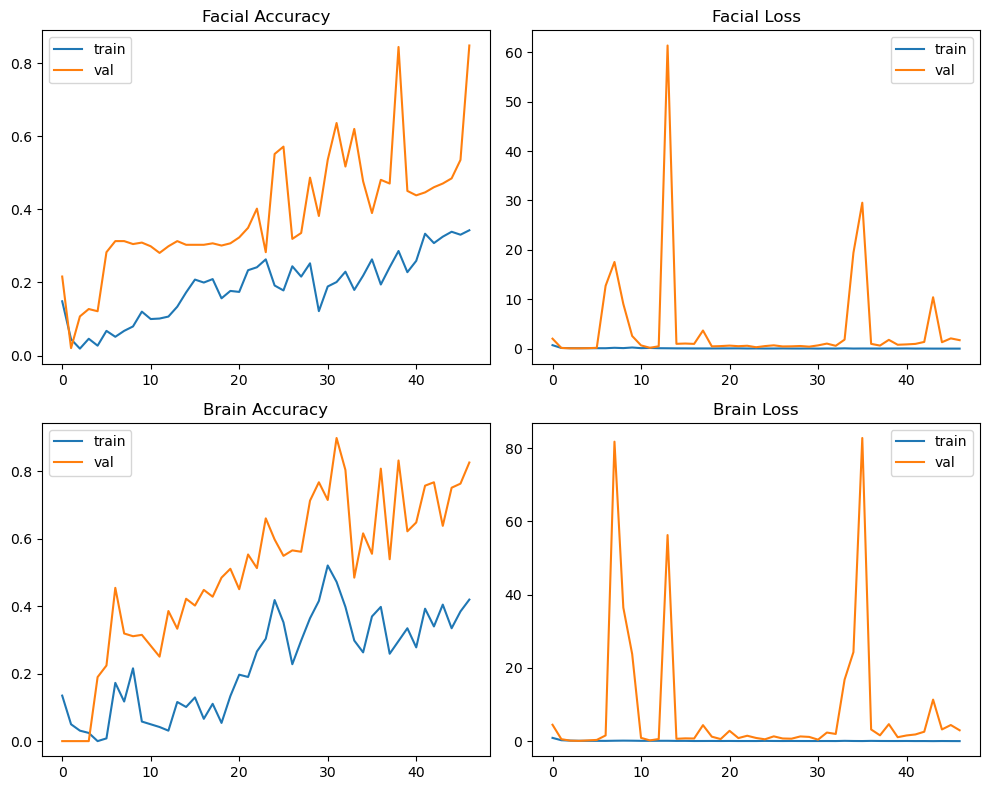

In [22]:
# create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

# plot the training and validation accuracy for facial
axes[0][0].plot(model.history.history['facial_accuracy'], label='train')
axes[0][0].plot(model.history.history['val_facial_accuracy'], label='val')
axes[0][0].set_title('Facial Accuracy')
axes[0][0].legend()

# plot the training and validation loss for facial
axes[0][1].plot(model.history.history['facial_loss'], label='train')
axes[0][1].plot(model.history.history['val_facial_loss'], label='val')
axes[0][1].set_title('Facial Loss')
axes[0][1].legend()

# plot the training and validation accuracy for brain
axes[1][0].plot(model.history.history['brain_accuracy'], label='train')
axes[1][0].plot(model.history.history['val_brain_accuracy'], label='val')
axes[1][0].set_title('Brain Accuracy')
axes[1][0].legend()

# plot the training and validation loss for brain
axes[1][1].plot(model.history.history['brain_loss'], label='train')
axes[1][1].plot(model.history.history['val_brain_loss'], label='val')
axes[1][1].set_title('Brain Loss')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [30]:
fig.savefig('figure.png')

In [23]:
model.load_weights("project.h5")

In [24]:
predictions = np.where(np.array(model.predict(X_test)) > 0.5, 1, 0)
print(predictions)

26/26 [==============================] - 5s 134ms/step
[[[0]
  [0]
  [1]
  ...
  [0]
  [0]
  [0]]

 [[1]
  [1]
  [0]
  ...
  [1]
  [1]
  [1]]]


In [25]:
tests_facial=[]
for i in Y_f_test:
    tests_facial.append([i])
tests_facial[:2]

[[0], [0]]

In [26]:
tests_brain=[]
for i in Y_b_test:
    tests_brain.append([i])
tests_brain[:2]

[[1], [1]]

In [27]:
m = BinaryAccuracy()
m.update_state(tests_facial, predictions[0])
acc_facial = m.result().numpy() * 100

m.reset_state()
m.update_state(tests_brain, predictions[1])
acc_brain = m.result().numpy() * 100

print("Facial Accuracy: " + str(acc_facial))
print("Brain Accuracy: " + str(acc_brain))

Facial Accuracy: 98.66504669189453
Brain Accuracy: 98.05825352668762


In [28]:
f1_facial = f1_score(tests_facial, predictions[0])
f1_brain = f1_score(tests_brain, predictions[1])
print("Facial F1 score: " + str(f1_facial))
print("Brain F1 score: " + str(f1_brain))

Facial F1 score: 0.980461811722913
Brain F1 score: 0.9851301115241636


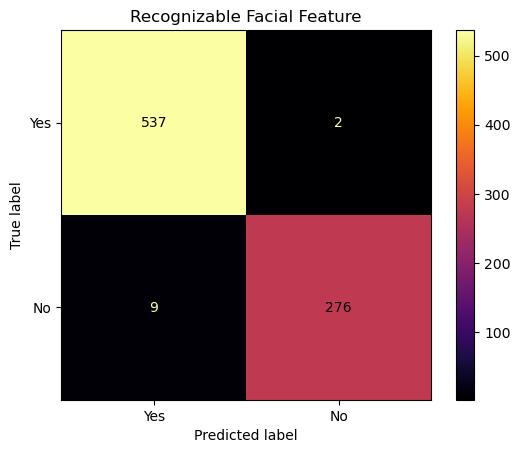

In [52]:
cm_display = ConfusionMatrixDisplay.from_predictions(
    predictions[0], Y_f_test, display_labels=['Yes', 'No'], cmap="inferno")
plt.title("Recognizable Facial Feature")
plt.show()

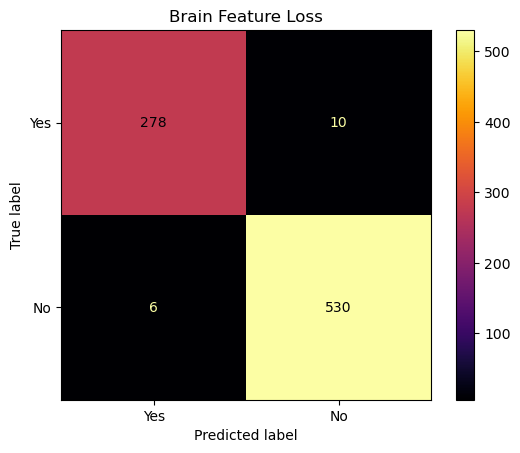

In [53]:
cm_display = ConfusionMatrixDisplay.from_predictions(
    predictions[1], Y_b_test, display_labels=['Yes', 'No'], cmap="inferno")
plt.title("Brain Feature Loss")
plt.show()